In [188]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [189]:
url = "https://raw.githubusercontent.com/Pahandrovich/MachineLearningCourse/master/data/concatenated/adult_full.data"
data_raw = pd.read_csv(url,
                       names=['age','workclass','fnlwgt','education','education-num','marital-status',
                              'occupation','relationship','race','sex','capital-gain','capital-loss',
                              'hours-per-week','native-country','label'],
                       na_values=['?'],
                       sep=r'\s*,\s*',
                       engine='python')
data_raw.shape

(48842, 15)

In [190]:
data_raw.head(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [191]:
data_raw['label'] = pd.factorize(data_raw['label'])[0]
data_raw['sex']   = pd.factorize(data_raw['sex'])  [0]
data_raw = data_raw.drop(['fnlwgt'], axis=1)
data_raw = data_raw.drop(['capital-loss'], axis=1)
data_raw.head(5)

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,hours-per-week,native-country,label
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,0,2174,40,United-States,0
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,0,0,13,United-States,0
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,0,0,40,United-States,0
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,0,0,40,United-States,0
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,1,0,40,Cuba,0


# equivalents of binary feature
---
0 label ~ <= 50K  
1 label ~ >  50K  

---

0 sex ~ Male   
1 sex ~ Female 

---

In [192]:
data_raw.isna().sum()

age                  0
workclass         2799
education            0
education-num        0
marital-status       0
occupation        2809
relationship         0
race                 0
sex                  0
capital-gain         0
hours-per-week       0
native-country     857
label                0
dtype: int64

In [193]:
data_raw = data_raw.dropna()
data_raw.isna().sum()

age               0
workclass         0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
hours-per-week    0
native-country    0
label             0
dtype: int64

In [194]:
data_raw['workclass'] = data_raw['workclass'].astype('category')
data_raw['education'] = data_raw['education'].astype('category')
data_raw['marital-status'] = data_raw['marital-status'].astype('category')
data_raw['occupation'] = data_raw['occupation'].astype('category')
data_raw['relationship'] = data_raw['relationship'].astype('category')
data_raw['race'] = data_raw['race'].astype('category')
data_raw['native-country'] = data_raw['native-country'].astype('category')

Text(0, 0.5, 'education-num')

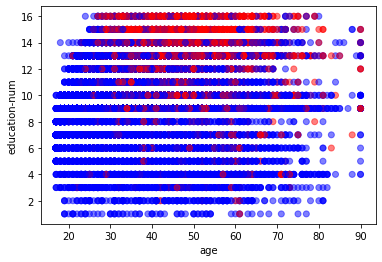

In [195]:
plt.scatter(data_raw['age'], data_raw['education-num'], color = np.array(('b', 'r'))[data_raw['label']], alpha = 0.5)
plt.xlabel('age')
plt.ylabel('education-num')

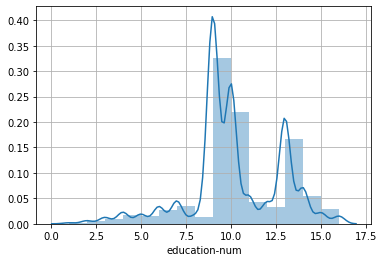

In [196]:
sns.distplot(data_raw['education-num'], bins=15)
plt.grid()

In [197]:
data_raw['native-country'].value_counts()

United-States                 41292
Mexico                          903
Philippines                     283
Germany                         193
Puerto-Rico                     175
Canada                          163
El-Salvador                     147
India                           147
Cuba                            133
England                         119
China                           113
Jamaica                         103
South                           101
Italy                           100
Dominican-Republic               97
Japan                            89
Guatemala                        86
Vietnam                          83
Columbia                         82
Poland                           81
Haiti                            69
Portugal                         62
Iran                             56
Taiwan                           55
Greece                           49
Nicaragua                        48
Peru                             45
Ecuador                     

In [198]:
data_raw['capital-gain'].value_counts()

0        41432
15024      498
7688       391
7298       351
99999      229
         ...  
1731         1
22040        1
7262         1
1639         1
2387         1
Name: capital-gain, Length: 121, dtype: int64

In [199]:
data_raw['age'].value_counts()

36    1283
33    1279
31    1274
35    1272
23    1241
      ... 
85       5
88       5
86       1
87       1
89       1
Name: age, Length: 74, dtype: int64

In [200]:
print(data_raw.shape)
rows_to_drop = data_raw[
    (data_raw['age'] >= 86) | (data_raw['native-country'] == 'Holand-Netherlands') |
    (data_raw['workclass'] == 'Without-pay') | (data_raw['occupation'] == 'Priv-house-serv') | 
    (data_raw['occupation'] == 'Armed-Forces') | (data_raw['occupation'] == 'Protective-serv')].index
data = data_raw.drop(rows_to_drop)
print(data.shape)

(45222, 13)
(43925, 13)


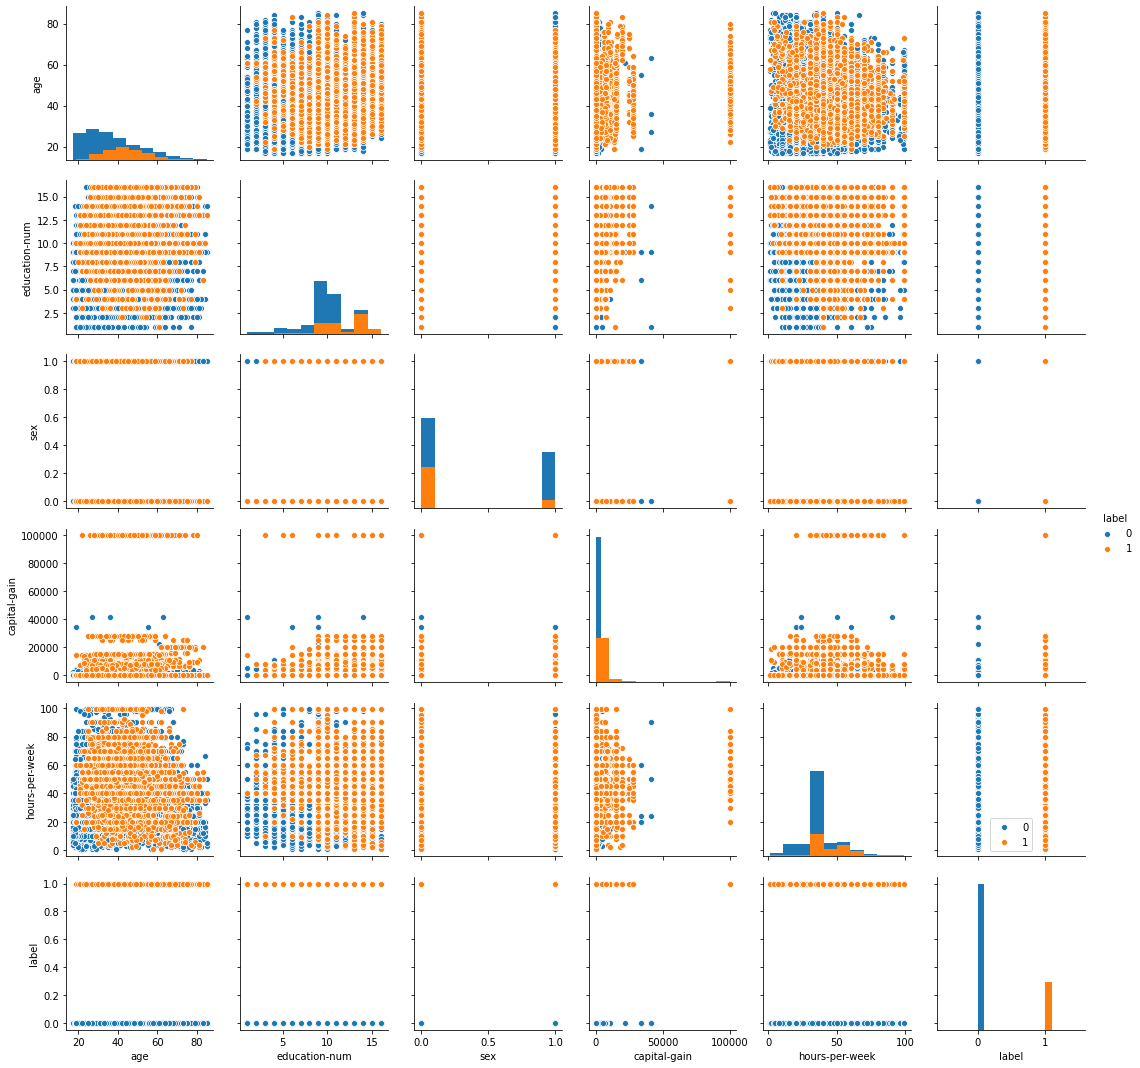

In [201]:
sns.pairplot(data, hue='label', diag_kind='hist')
plt.legend()

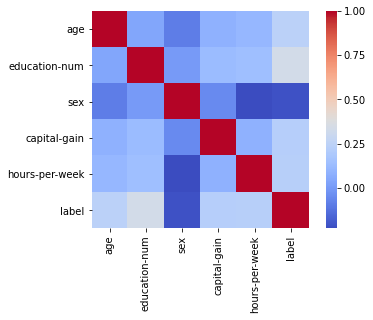

In [202]:
corr_mat = data.corr()
sns.heatmap(corr_mat, square=True, cmap='coolwarm')

In [203]:
from sklearn.preprocessing import LabelEncoder


X = data.drop(['label'], axis=1)
y = data['label']

# workclass
le_workclass = LabelEncoder()
le_workclass.fit(X['workclass'])
X['workclass'] = le_workclass.transform(X['workclass'])
# education
le_education = LabelEncoder()
le_education.fit(X['education'])
X['education'] = le_education.transform(X['education'])
# marital-status
le_marital_status = LabelEncoder()
le_marital_status.fit(X['marital-status'])
X['marital-status'] = le_marital_status.transform(X['marital-status'])
# occupation
le_occupation = LabelEncoder()
le_occupation.fit(X['occupation'])
X['occupation'] = le_occupation.transform(X['occupation'])
# relationship
le_relationship = LabelEncoder()
le_relationship.fit(X['relationship'])
X['relationship'] = le_relationship.transform(X['relationship'])
# race
le_race = LabelEncoder()
le_race.fit(X['race'])
X['race'] = le_race.transform(X['race'])
# native-country
le_native_country = LabelEncoder()
le_native_country.fit(X['native-country'])
X['native-country'] = le_native_country.transform(X['native-country'])

X.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,hours-per-week,native-country
0,39,5,9,13,4,0,1,4,0,2174,40,37
1,50,4,9,13,2,2,0,4,0,0,13,37
2,38,2,11,9,0,4,1,4,0,0,40,37
3,53,2,1,7,2,4,0,2,0,0,40,37
4,28,2,9,13,2,7,5,2,1,0,40,4


In [204]:
print(X.shape)
print(y.shape)

(43925, 12)
(43925,)


In [205]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

### KNeighborsClassifier

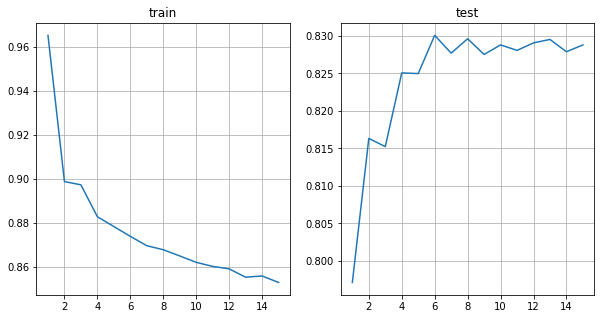

In [206]:
min_k = 1
max_k = 15
scores_train = []
scores_test = []
for k in range(min_k,max_k + 1):
    knc = KNeighborsClassifier(n_neighbors = k)
    knc.fit(X_train, y_train)
    scores_train.append(knc.score(X_train,y_train))
    scores_test.append(knc.score(X_test,y_test))

#plt.plot(range(min_k,max_k + 1),scores_train)
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(10, 5))

ax[0].set_title("train")
ax[0].plot(range(min_k,max_k + 1),scores_train)
ax[1].set_title("test")
ax[1].plot(range(min_k,max_k + 1),scores_test)
ax[0].grid(True)
ax[1].grid(True)
plt.show()
    



### RandomForestClassifier

In [207]:
rfc = RandomForestClassifier(
                 n_estimators=100,
                 criterion="gini",
                 max_depth=4,
                 min_samples_split=2,
                 min_samples_leaf=5,
                 min_weight_fraction_leaf=0.,
                 max_features="auto",
                 max_leaf_nodes=None,
                 min_impurity_decrease=0.,
                 min_impurity_split=None,
                 bootstrap=True,
                 oob_score=False,
                 n_jobs=None,
                 random_state=42,
                 verbose=0,
                 warm_start=False,
                 class_weight=None,
                 ccp_alpha=0.0,
                 max_samples=None)
rfc.fit(X_train,y_train)
print(f"train score = {rfc.score(X_train,y_train)}")
print(f"test  score = {rfc.score(X_test,y_test)}")

train score = 0.8407552439061409
test  score = 0.8339100346020761
